In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

## Get the data

This is the simulated data used in the DeepLIFT paper. The the pwms for the GATA motif and TAL motif (GATA_disc1 and TAL1_known1 from http://compbio.mit.edu/encode-motifs/) are used to generate motifs which are inserted into a random background. Sequences containing at least one GATA motif are a 1 for task 1, 0 otherwise. Sequences containing at least one TAL motif are a 1 for task 2, 0 otherwise. Sequences containing both a TAL and a GATA motif are a 1 for task 0. 

In [2]:
!./grab_data.sh

File sequences.simdata.gz exists already


In [3]:
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install -e "git://github.com/kundajelab/simdna.git@0.4.0#egg=simdna"
    print("\n******************************************************************************")
    print("RESTART THE JUPYTER KERNEL TO PICK UP ON THE INSTALLATION!!!")
    print("******************************************************************************")

In [4]:
import simdna.synthetic as synthetic
import gzip

data_filename = "sequences.simdata.gz"
data = synthetic.read_simdata_file(data_filename)

One-hot encode the sequence data into a 3d array, where the last axis ("channel" axis) is the ACGT axis.

In [5]:
print(data.labels[:,0])
print(data.labels[:,1])
print(data.labels[:,2])

[0 0 1 ... 1 0 0]
[0 1 1 ... 1 1 0]
[0 0 1 ... 1 0 0]


In [6]:
import numpy as np

print(data.labels.shape[0])
task0_indices = np.nonzero(data.labels[:,0] == 1)[0]
task1only_indices = np.nonzero((data.labels[:,1] == 1)*(data.labels[:,2] == 0))[0]
task2only_indices = np.nonzero((data.labels[:,1] == 0)*(data.labels[:,2] == 1))[0]
background_indices = np.nonzero(np.sum(data.labels,axis=1)==0)[0]
print(task0_indices)
print(task1only_indices)
print(task2only_indices)
print(background_indices)
print(len(background_indices))

8000
[   2    7    9 ... 7989 7990 7997]
[   1   12   19 ... 7994 7996 7998]
[   5    6   13 ... 7988 7991 7992]
[   0    3    4 ... 7987 7995 7999]
2000


In [7]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])
print(onehot_data.shape)

(8000, 200, 4)


## Compute the gapped kmer embeddings

We will compute the embeddings using the GPU to scan for matches to the gapped kmers, allowing for some numbed of mismatches. First, we will prepare the function that is going to do our scanning on the GPU.

In [8]:
import ssvmimp
import ssvmimp.train

max_mismatches=0

filters, string_reps, embedding_func = ssvmimp.train.get_gapped_kmer_embedding_filters_and_func(
                                kmer_len=6, alphabet=['A','C','G','T'],
                                num_gaps=1, max_mismatches=max_mismatches)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN not available)
WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /users/avanti/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/tmpAjDCY8/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '8171' (I am process '10293')


'string_reps' stores string representations of the filters, as shown below (gaps are indicated with whitespace):

In [9]:
print("Number of filters:",len(string_reps))
print("First ten filters:")
print("\n".join(string_reps[:10]))
print("Last ten filters:")
print("\n".join(string_reps[-10:]))

Number of filters: 5120
First ten filters:
AAAAA 
AAAAC 
AAAAG 
AAAAT 
AAACA 
AAACC 
AAACG 
AAACT 
AAAGA 
AAAGC 
Last ten filters:
T TTCG
T TTCT
T TTGA
T TTGC
T TTGG
T TTGT
T TTTA
T TTTC
T TTTG
T TTTT


Now, we compute the embeddings, which are the sum of the number of matches to each filter per sequence, accounting for the desired number of mismatches

In [10]:
embeddings = embedding_func(onehot=onehot_data, batch_size=20, progress_update=500)
print("Shape of the embeddings matrix:",embeddings.shape)

Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
Done 6500
Done 7000
Done 7500
Shape of the embeddings matrix: (8000, 5120)


Limit features to gkmers that are statistically overrepresented in the positive set

In [11]:
train_set_num = 6000 #6000 examples will be used in the training set
train_embeddings = embeddings[:train_set_num]
kmer_counts_positives = np.sum(train_embeddings[data.labels[:train_set_num,0]==1]>0,axis=0)
kmer_counts_negatives = np.sum(train_embeddings[data.labels[:train_set_num,0]==0]>0,axis=0)
total_positives = np.sum(data.labels[:train_set_num,0])
total_negatives = np.sum(1-data.labels[:train_set_num,0])

In [12]:
import ssvmimp.stats.stats
reload(ssvmimp.stats.stats)

significant_kmer_indices = []
for i,(kmer_count_pos, kmer_count_neg) in enumerate(zip(kmer_counts_positives, kmer_counts_negatives)):
    total = total_positives + total_negatives
    special = total_positives
    picked = kmer_count_pos+kmer_count_neg
    specialPicked = kmer_count_pos
    result = ssvmimp.stats.stats.proportionTest(
                total=total, special=special,
                picked=picked, specialPicked=specialPicked)
    if (result.pval < 0.05):
        significant_kmer_indices.append(i)

print(len(significant_kmer_indices))

530


Normalize the embeddings so that the rows have unit magnitude. Only consider overrepresented kmers

In [13]:
normalized_embeddings = (embeddings[:,significant_kmer_indices]/
                         np.linalg.norm(embeddings[:,significant_kmer_indices], axis=1)[:,None])
print("Normalized embeddings shape:",normalized_embeddings.shape)

Normalized embeddings shape: (8000, 530)


In [14]:
mean_bg_embedding = np.mean(embeddings[background_indices][:,significant_kmer_indices],axis=0)
mean_bg_embedding = mean_bg_embedding/np.linalg.norm(mean_bg_embedding)
print(mean_bg_embedding.shape)

mean_task1only_embedding = np.mean(embeddings[task1only_indices][:,significant_kmer_indices],axis=0)
mean_task1only_embedding = mean_task1only_embedding/np.linalg.norm(mean_task1only_embedding)
print(mean_task1only_embedding.shape)

mean_task2only_embedding = np.mean(embeddings[task2only_indices][:,significant_kmer_indices],axis=0)
mean_task2only_embedding = mean_task2only_embedding/np.linalg.norm(mean_task2only_embedding)
print(mean_task2only_embedding.shape)

(530,)
(530,)
(530,)


## Train SVMs given the embeddings

In [15]:
import sklearn.svm
import sys

print("Training linear SVM for t0")
sys.stdout.flush()
t0_linear_classifier = sklearn.svm.LinearSVC().fit(X=normalized_embeddings[:train_set_num], y=data.labels[:train_set_num,0])
preds = t0_linear_classifier.predict(normalized_embeddings[train_set_num:])
print("Linear SVM accuracy for task",0,":",np.sum(data.labels[train_set_num:,0] == preds)/len(preds))

Training linear SVM for t0
Linear SVM accuracy for task 0 : 0.857


In [16]:
import sklearn.svm
t0_gaussian_classifier = sklearn.svm.SVC(C=1.0, kernel="rbf", gamma=1.0).fit(
                X=normalized_embeddings[:train_set_num],
                y=data.labels[:train_set_num,0])
preds = t0_gaussian_classifier.predict(normalized_embeddings[train_set_num:])
print("Gaussian SVM test accuracy for task",0,":",np.sum(data.labels[train_set_num:,0] == preds)/len(preds))
train_preds = t0_gaussian_classifier.predict(normalized_embeddings[:train_set_num])
print("Gaussian SVM train accuracy for task",0,":",np.sum(data.labels[:train_set_num,0] == train_preds)/len(train_preds))
print("Number of support vectors:",t0_gaussian_classifier.n_support_)

Gaussian SVM test accuracy for task 0 : 0.9485
Gaussian SVM train accuracy for task 0 : 0.9721666666666666
Number of support vectors: [1213  959]


# Calculate Feature/Filter contributions using average gradient from separating hyperplane

In [17]:
normalized_embeddings.shape

(8000, 530)

In [18]:
import ssvmimp.imp_scores_helper
reload(ssvmimp.imp_scores_helper)
from ssvmimp.imp_scores_helper import ImportanceScoresHelper
impscoreshelper = ImportanceScoresHelper(
    t0_gaussian_classifier, 1.0,
    normalized_embeddings[:train_set_num], 
    data.labels[:train_set_num,0] )
#impscores_default_ref = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
#                normalized_embeddings[task0_indices[:10]],
#                reference_to_use=None,
#                numsteps=10)
impscores_bgref, avggrad_bgref =\
    impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
                normalized_embeddings[task0_indices[:]],
                reference_to_use=np.array([mean_bg_embedding for x in
                                            task0_indices[:]]),
                numsteps=10)
print(impscores_bgref.shape)
print(avggrad_bgref.shape)
impscores_task1ref, avggrad_task1ref = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
                normalized_embeddings[task0_indices[:10]],
                reference_to_use=[mean_task1only_embedding for x in task0_indices[:10]],
                numsteps=10)
impscores_task2ref, avggrad_task2ref = impscoreshelper.get_feature_contribs_using_average_gradient_from_reference(
                normalized_embeddings[task0_indices[:10]],
                reference_to_use=[mean_task2only_embedding for x in task0_indices[:10]],
                numsteps=10)

Starting average gradient calculation for  100 th point
Starting average gradient calculation for  200 th point
Starting average gradient calculation for  300 th point
Starting average gradient calculation for  400 th point
Starting average gradient calculation for  500 th point
Starting average gradient calculation for  600 th point
Starting average gradient calculation for  700 th point
Starting average gradient calculation for  800 th point
Starting average gradient calculation for  900 th point
Starting average gradient calculation for  1000 th point
Starting average gradient calculation for  1100 th point
Starting average gradient calculation for  1200 th point
Starting average gradient calculation for  1300 th point
Starting average gradient calculation for  1400 th point
Starting average gradient calculation for  1500 th point
Starting average gradient calculation for  1600 th point
Starting average gradient calculation for  1700 th point
Starting average gradient calculation fo

# Calculate Importance Scores for Task 1 sequences (GATA motif only)

In [20]:
import ssvmimp.backend.theano_backend
reload(ssvmimp.backend.theano_backend)
import ssvmimp.backend
reload(ssvmimp.backend)

interpretation_func = ssvmimp.backend.get_interpretation_func_dynamic_filter_imp(
                            filters=filters[significant_kmer_indices])
hyp_imp_func = ssvmimp.backend.get_interpretation_func_dynamic_hyp_contribs(
                            filters=filters[significant_kmer_indices])

In [22]:
#defaultref_scores = interpretation_func(
#                    onehot=onehot_data[task0_indices[:10]],
#                    filter_imp=impscores_default_ref,
#                    batch_size=20, progress_update=20)
bgref_scores = interpretation_func(
                    onehot=onehot_data[task0_indices[:]],
                    filter_grad=avggrad_bgref,
                    batch_size=20, progress_update=100)
print(bgref_scores.shape)
bgref_hyp_scores = hyp_imp_func(
                    onehot=onehot_data[task0_indices[:]],
                    filter_grad=avggrad_bgref,
                    batch_size=20, progress_update=100)
bgref_hyp_scores = bgref_hyp_scores-np.mean(bgref_hyp_scores,axis=-1)[:,:,None]
print(bgref_hyp_scores.shape)
task1onlyref_scores = interpretation_func(
                    onehot=onehot_data[task0_indices[:10]],
                    filter_grad=avggrad_task1ref[:10],
                    batch_size=20, progress_update=20)
task1onlyref_hyp_scores = hyp_imp_func(
                    onehot=onehot_data[task0_indices[:10]],
                    filter_grad=avggrad_task1ref[:10],
                    batch_size=20, progress_update=100)
task1onlyref_hyp_scores = task1onlyref_hyp_scores-np.mean(task1onlyref_hyp_scores,axis=-1)[:,:,None]
task2onlyref_scores = interpretation_func(
                    onehot=onehot_data[task0_indices[:10]],
                    filter_grad=avggrad_task2ref[:10],
                    batch_size=20, progress_update=20)
task2onlyref_hyp_scores = hyp_imp_func(
                    onehot=onehot_data[task0_indices[:10]],
                    filter_grad=avggrad_task2ref[:10],
                    batch_size=20, progress_update=100)
task2onlyref_hyp_scores = task2onlyref_hyp_scores-np.mean(task2onlyref_hyp_scores,axis=-1)[:,:,None]

Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000
Done 1100
Done 1200
Done 1300
Done 1400
Done 1500
Done 1600
Done 1700
Done 1800
Done 1900
(2000, 200, 4)
Done 0
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000
Done 1100
Done 1200
Done 1300
Done 1400
Done 1500
Done 1600
Done 1700
Done 1800
Done 1900
(2000, 200, 4)
Done 0
Done 0
Done 0
Done 0


Example 0
Background reference scores:


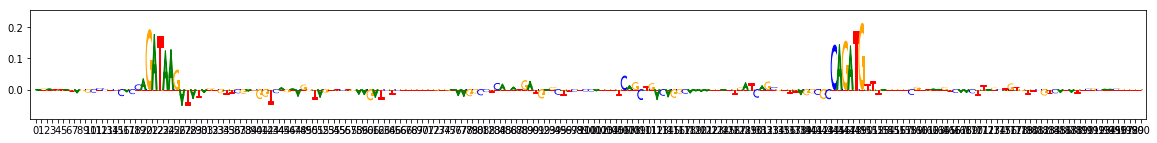

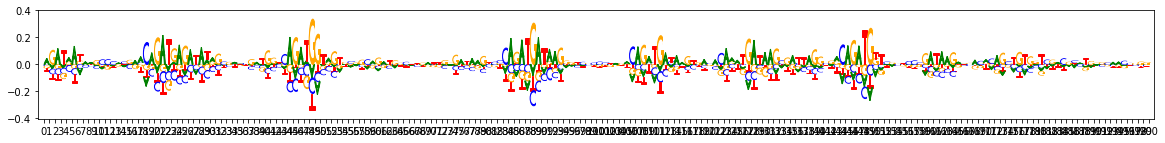

Scores with task1only example as reference:


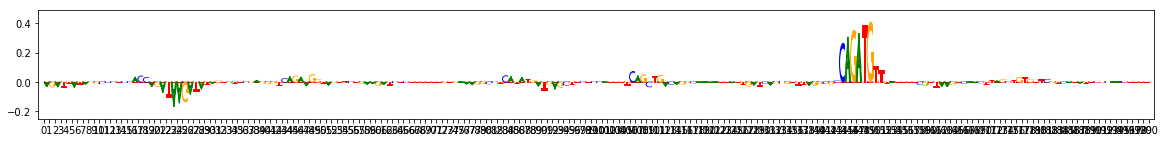

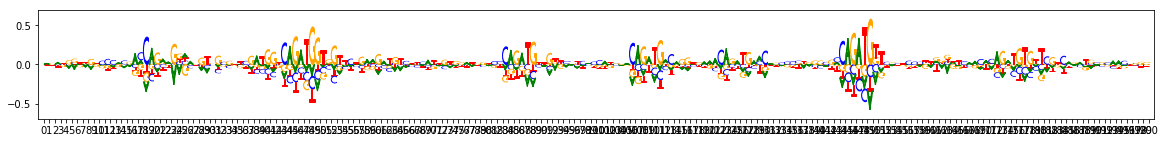

Scores with task2only example as reference:


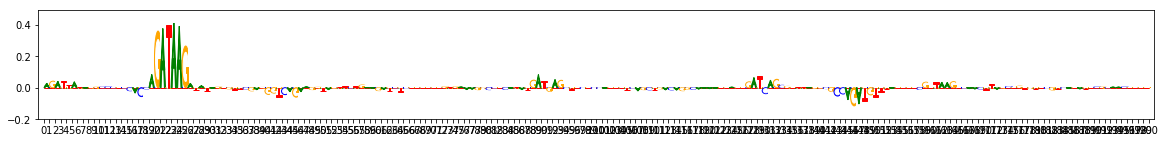

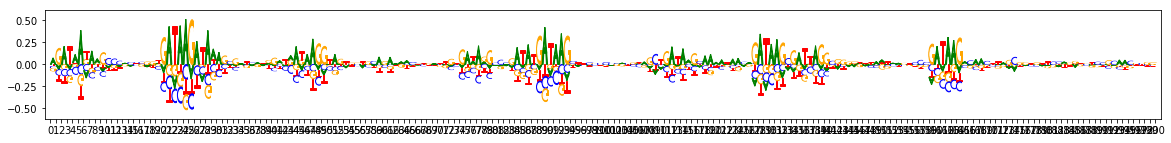

Example 1
Background reference scores:


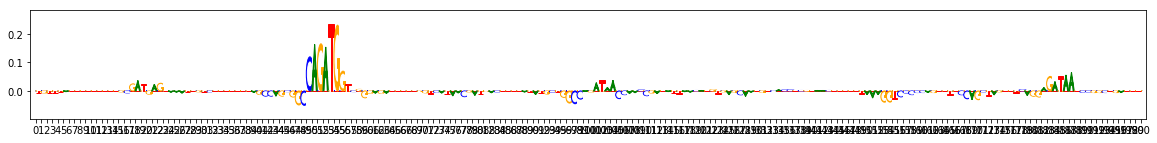

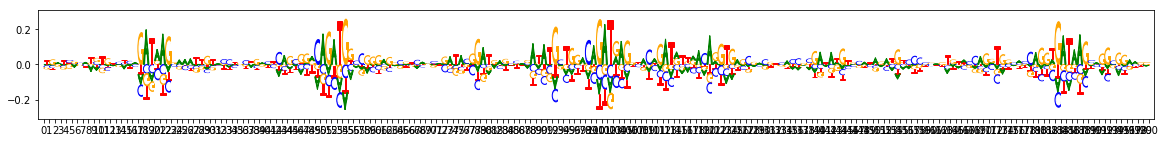

Scores with task1only example as reference:


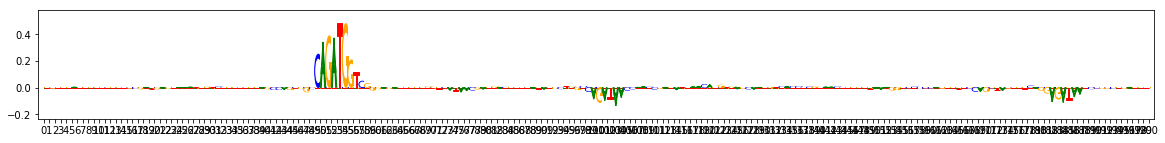

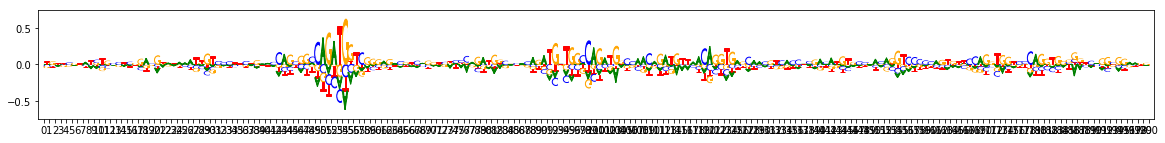

Scores with task2only example as reference:


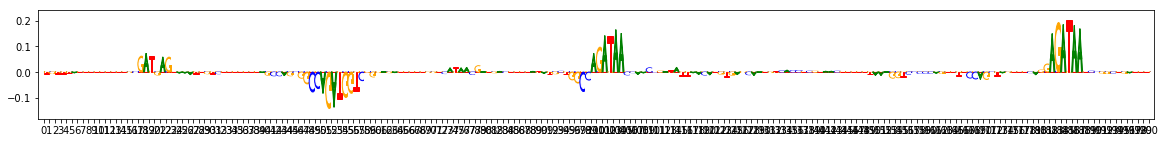

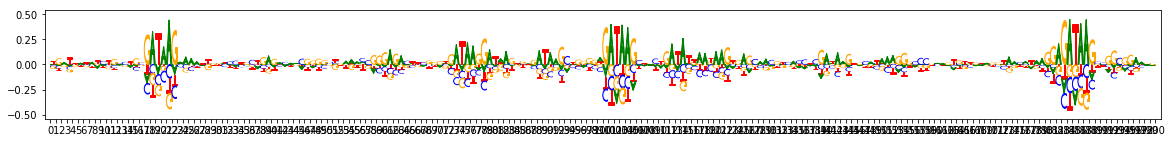

Example 2
Background reference scores:


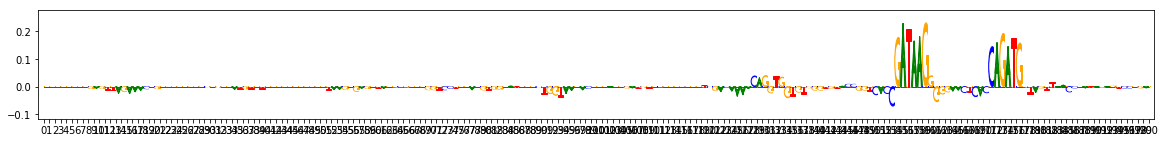

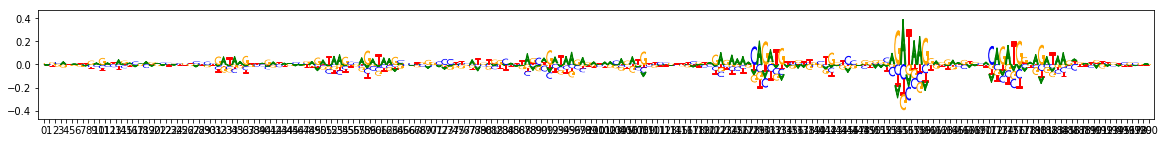

Scores with task1only example as reference:


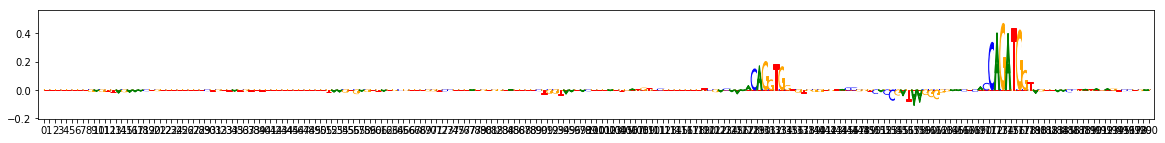

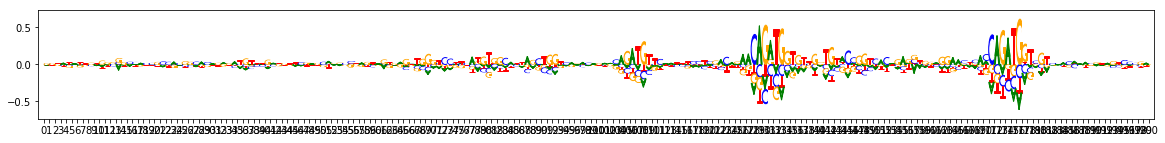

Scores with task2only example as reference:


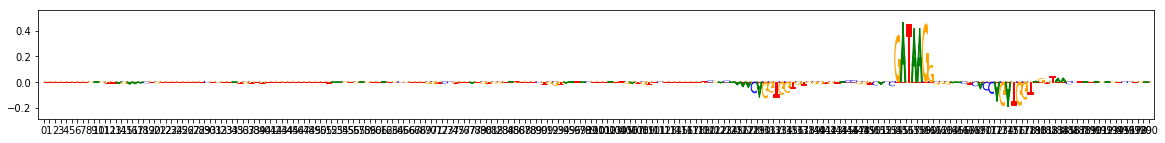

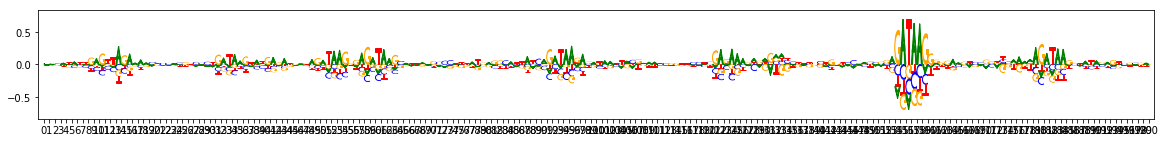

In [23]:
import ssvmimp.viz_sequence
%matplotlib inline

for i,(bgref_scores_for_seq, bgref_hyp_scores_for_seq,
       task1onlyref_scores_for_seq,
       task1onlyref_hyp_scores_for_seq,
       task2onlyref_scores_for_seq,
       task2onlyref_hyp_scores_for_seq,
      ) in enumerate(zip(bgref_scores[:3],
                         bgref_hyp_scores[:3],
                         task1onlyref_scores[:3],
                         task1onlyref_hyp_scores[:3],
                         task2onlyref_scores[:3],
                         task2onlyref_hyp_scores[:3])):
    print("Example",i)
    print("Background reference scores:")
    ssvmimp.viz_sequence.plot_weights(bgref_scores_for_seq)
    ssvmimp.viz_sequence.plot_weights(bgref_hyp_scores_for_seq)
    print("Scores with task1only example as reference:")
    ssvmimp.viz_sequence.plot_weights(task1onlyref_scores_for_seq)
    ssvmimp.viz_sequence.plot_weights(task1onlyref_hyp_scores_for_seq)
    print("Scores with task2only example as reference:")
    ssvmimp.viz_sequence.plot_weights(task2onlyref_scores_for_seq)
    ssvmimp.viz_sequence.plot_weights(task2onlyref_hyp_scores_for_seq)

In [23]:
np.save("task0importancescores.npy",bgref_scores)
np.save("task0hypimpscores.npy",bgref_hyp_scores)